## SARIMAX

In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from common.utils import load_data, mape

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


load the data

In [3]:
data_dir = 'D:\Code\ML\Machine_Learning\Data'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


### Create training and testing datasets

Allocate a two-month period from Nov 1 to Dec 31, 2014 to the data set. The last 2 days belongs to the test set

In [4]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

Visualize the differences

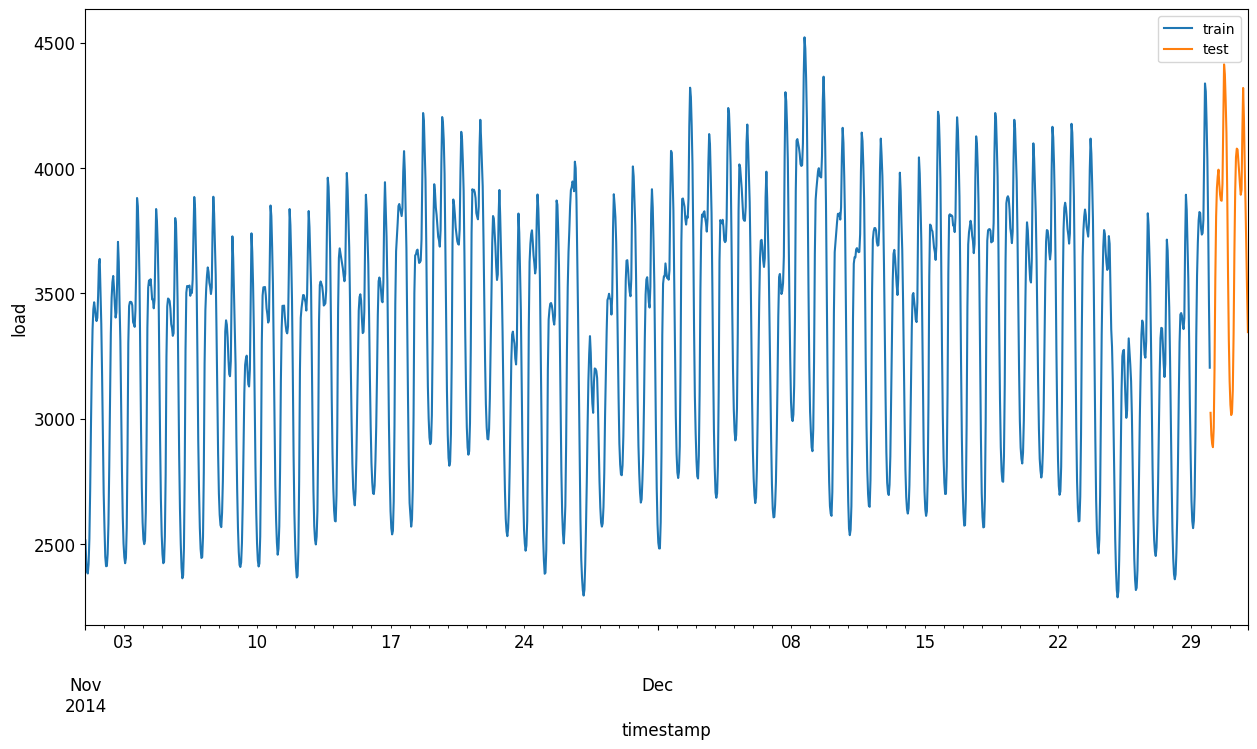

In [5]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


Prepare the data for training

In [6]:
# Filter
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('train.shape:', train.shape)
print('test.shape:', test.shape)

train.shape: (1416, 1)
test.shape: (48, 1)


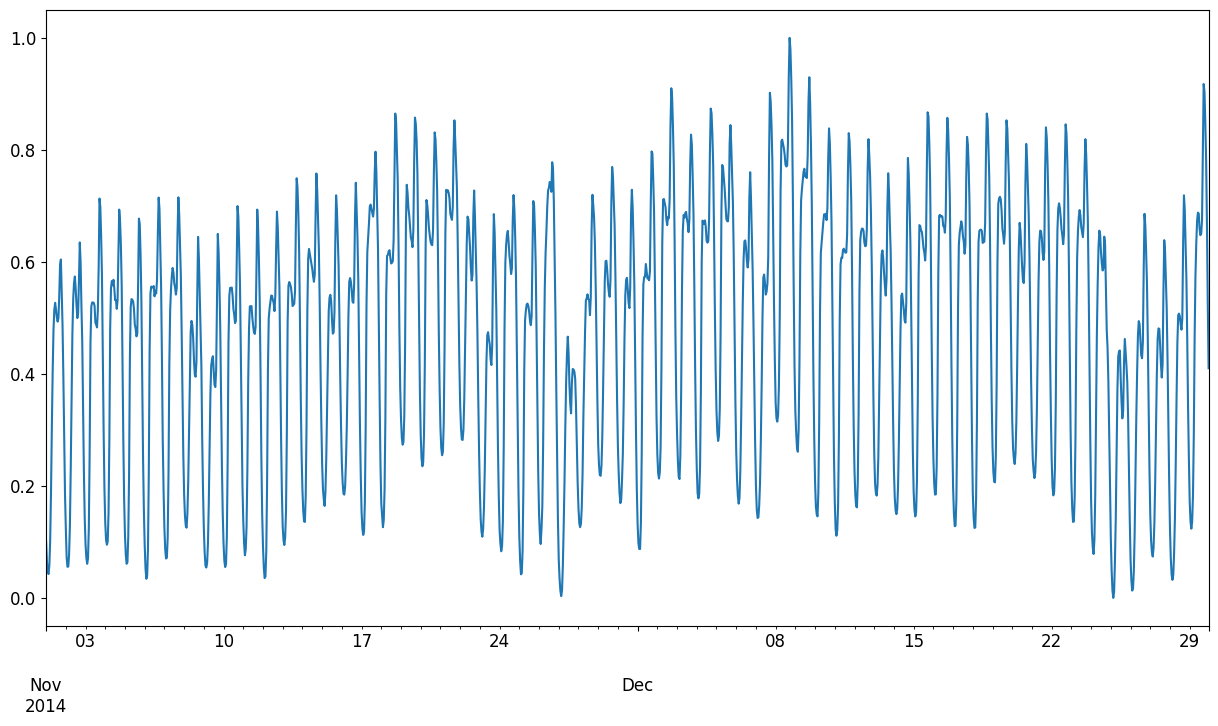

In [7]:
# Scale
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train['load'].plot(figsize=(15, 8), fontsize=12)
test['load'] = scaler.transform(test)


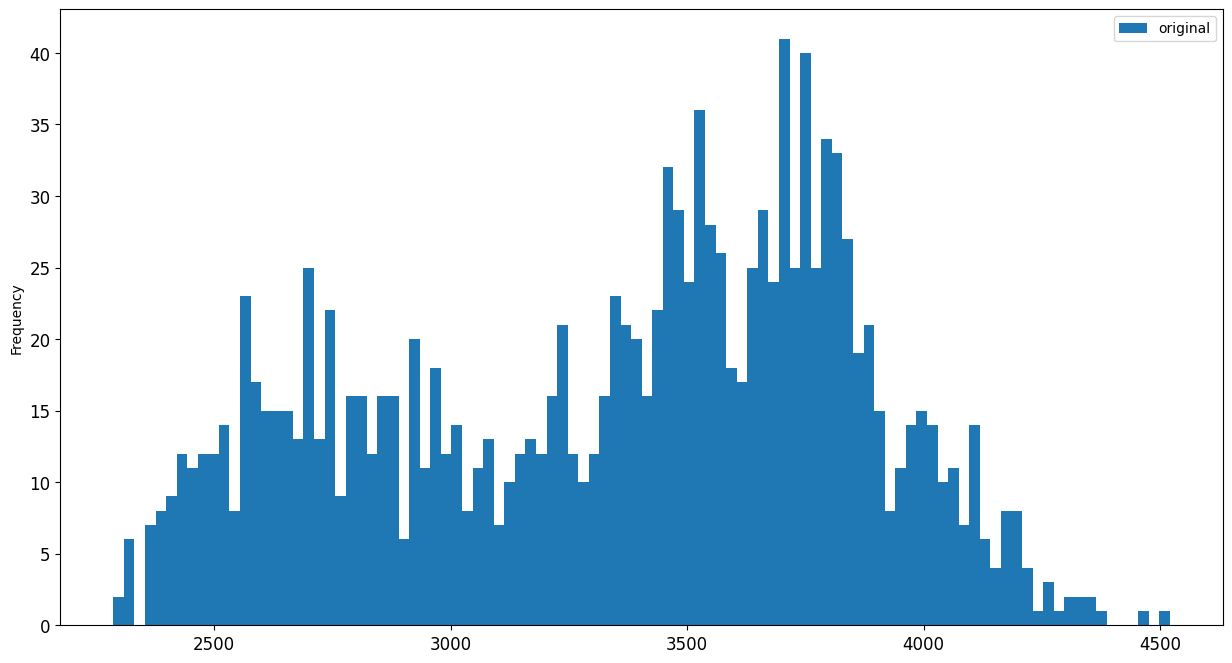

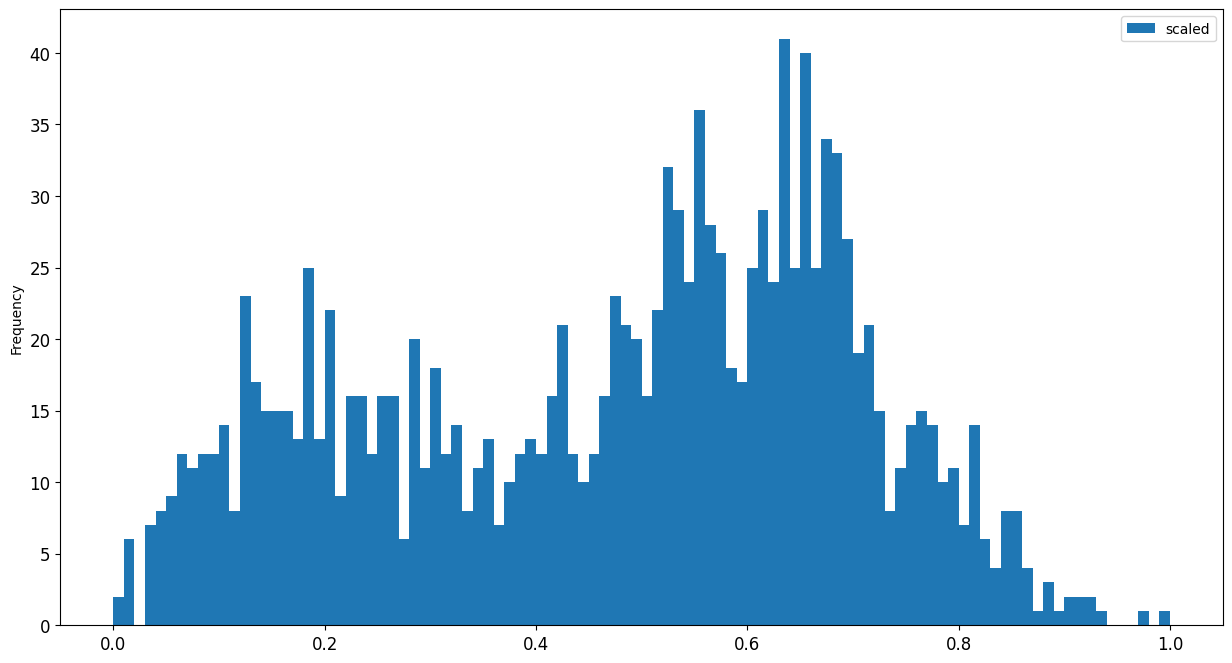

In [8]:
# Visualize the original and scaled data
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original'}).plot.hist(bins=100, fontsize=12, figsize=(15, 8))
train.rename(columns={'load':'scaled'}).plot.hist(bins=100, fontsize=12, figsize=(15, 8))
plt.show()

### Implement ARIMA

Set preferred horizon value

In [9]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print("Forecasting horizon:", HORIZON, "hours")

Forecasting horizon: 3 hours


try some manual selections to find a good model

In [10]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
result = model.fit()

print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.226
Date:                            Fri, 04 Oct 2024   AIC                          -6942.452
Time:                                    12:46:26   BIC                          -6911.025
Sample:                                11-01-2014   HQIC                         -6930.700
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8404      0.016     52.351      0.000       0.809       0.872
ar.L2         -0.5203      0.034   

### Evaluate the model

create a test data point for each HORIZON step

In [11]:
test_shifted = test.copy() 
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head()

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


make predictions on test data using sliding window approach in a loop the size of the test data length:

In [12]:
%%time

train_window = 720 # dedicate 30 days (720 hours) for training
train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-train_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)

    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.67] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

compare the predictions to the actual load:

In [26]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head(10)

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,008.68","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,955.50","2,935.00"
2,2014-12-30 02:00:00,t+1,"2,900.12","2,899.00"
3,2014-12-30 03:00:00,t+1,"2,917.77","2,886.00"
4,2014-12-30 04:00:00,t+1,"2,946.80","2,963.00"
5,2014-12-30 05:00:00,t+1,"3,180.79","3,199.00"
6,2014-12-30 06:00:00,t+1,"3,558.83","3,558.00"
7,2014-12-30 07:00:00,t+1,"3,807.54","3,806.00"
8,2014-12-30 08:00:00,t+1,"3,959.16","3,920.00"
9,2014-12-30 09:00:00,t+1,"3,996.32","3,965.00"


### Check model accuracy

In [14]:
if(HORIZON > 1):
    eval_df['APE'] = mape(eval_df['prediction'], eval_df['actual'])
    print(eval_df.groupby('h')['APE'].mean())

# calculate one step's MAPE
print('One step forecast MAPE: ', (mape(eval_df[eval_df.h == 't+1']['prediction'], eval_df[eval_df.h == 't+1']['actual'])*100), '%')

# calculate the multi-step forecast MAPE
print('Multi-step forecast MAPE: ', (mape(eval_df['prediction'], eval_df['actual'])*100), '%')

h
t+1   0.01
t+2   0.01
t+3   0.01
Name: APE, dtype: float64
One step forecast MAPE:  0.5567739554418987 %
Multi-step forecast MAPE:  1.1452372595477889 %


see this kind of accuracy measurement visually

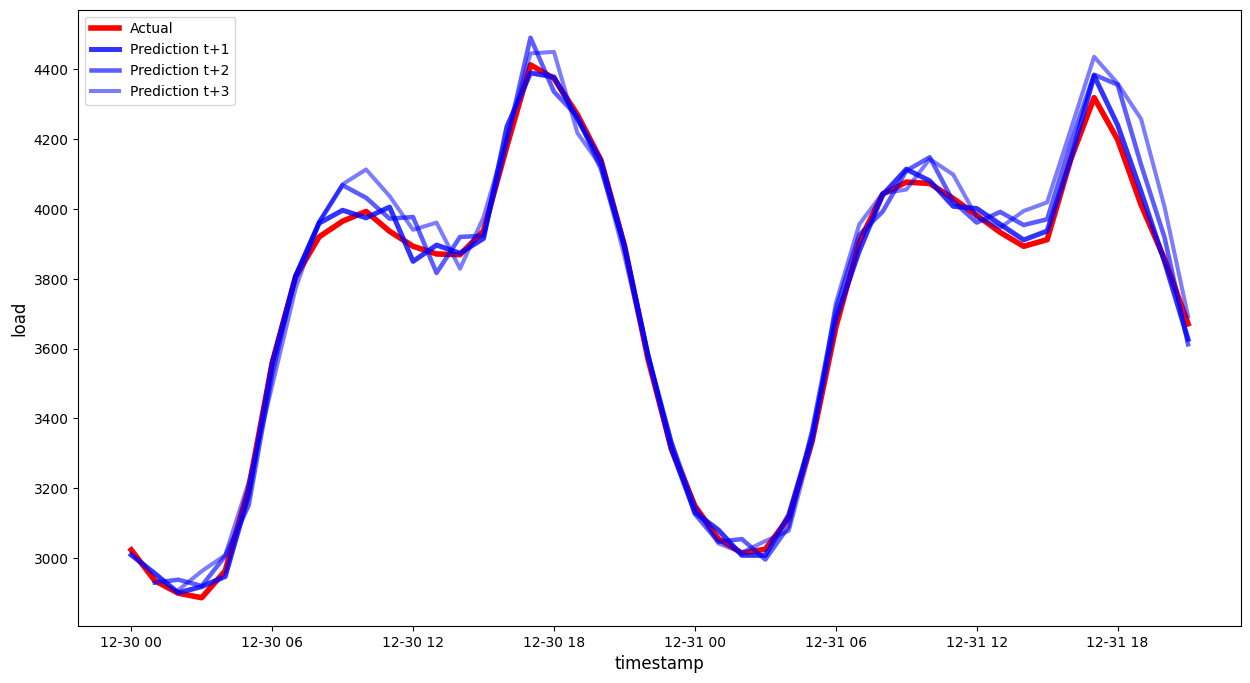

In [29]:
if HORIZON == 1:
    # Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))
else:
    # Plotting multi step forecast
    plot_df = eval_df[eval_df.h == 't+1'][['timestamp', 'actual']]
    for t in range(1, HORIZON + 1):
        plot_df['t+' + str(t)] = eval_df[eval_df.h == 't+' + str(t)]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    
    # Plot actual values
    ax.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0, label='Actual')
    
    # Plot predicted values
    for t in range(1, HORIZON + 1):
        x = plot_df['timestamp'][(t - 1):]
        y = plot_df['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t), label=f'Prediction t+{t}')

    ax.legend(loc='best')

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()